# Module 4.2. Compile the pretrained PyTorch model from model zoo with SageMaker Neo
---

***[Before getting started] This notebook loads and compiles pre-trained models from model-zoo right away, so you can run them standalone. If you want to fine-tune or use the model-zoo instead of your own model, this notebook is convenient and useful.***

In this notebook, we compile and deploy a pre-trained model on the ImageNet dataset with SageMaker Neo. SageMaker Neo is an API that optimizes machine learning models for hardware, and models compiled with Neo can run anywhere in the cloud and on edge devices.

As of Sep. 2021, SageMaker Neo supports PyTorch 1.6.0 on cloud instances and edge devices, and PyTorch 1.5.1 on AWS Inferentia.

Please refer to the link below for instance types, hardware, and deep learning frameworks supported by SageMaker Neo.

- Cloud Instance: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-cloud.html
- Edge Device: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-devices-edge.html

This hands-on can be completed in about **10 minutes**. 

In [1]:
%load_ext autoreload
%autoreload 2
%store -r
%store

Stored variables and their in-db values:


In [2]:
import logging, sys
def _get_logger():
    '''
    로깅을 위해 파이썬 로거를 사용
    # https://stackoverflow.com/questions/17745914/python-logging-module-is-printing-lines-multiple-times
    '''
    loglevel = logging.DEBUG
    l = logging.getLogger(__name__)
    if not l.hasHandlers():
        l.setLevel(loglevel)
        logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))        
        l.handler_set = True
    return l  

logger = _get_logger()

In [3]:
import os, sys, sagemaker
sys.path.insert(0, "./src")
#!{sys.executable} -m pip install -qU "sagemaker>=2.45"
print(sagemaker.__version__)
model_trace_name = 'model.pth'
sample_img_path = "sample_images"

2.48.1


<br>

# 1. Inference script
---

The code cell below stores the SageMaker inference script in the `src` directory.

In [4]:
%%writefile src/infer_pytorch_neo.py

import io
import json
import logging
import os
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image  # Training container doesn't have this package

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


def model_fn(model_dir):
    import neopytorch

    logger.info("model_fn")
    neopytorch.config(model_dir=model_dir, neo_runtime=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # The compiled model is saved as "compiled.pt"
    model = torch.jit.load(os.path.join(model_dir, "compiled.pt"), map_location=device)

    # It is recommended to run warm-up inference during model load
    sample_input_path = os.path.join(model_dir, "sample_input.pkl")
    with open(sample_input_path, "rb") as input_file:
        model_input = pickle.load(input_file)
    if torch.is_tensor(model_input):
        model_input = model_input.to(device)
        model(model_input)
    elif isinstance(model_input, tuple):
        model_input = (inp.to(device) for inp in model_input if torch.is_tensor(inp))
        model(*model_input)
    else:
        print("Only supports a torch tensor or a tuple of torch tensors")

    return model
    
    
def transform_fn(model, payload, request_content_type='application/octet-stream', 
                 response_content_type='application/json'):

    logger.info('Invoking user-defined transform function')

    if request_content_type != 'application/octet-stream':
        raise RuntimeError(
            'Content type must be application/octet-stream. Provided: {0}'.format(request_content_type))

    # preprocess
    decoded = Image.open(io.BytesIO(payload))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[
                0.485, 0.456, 0.406], std=[
                0.229, 0.224, 0.225]),
    ])
    normalized = preprocess(decoded)
    batchified = normalized.unsqueeze(0)

    # predict
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batchified = batchified.to(device)
    result = model.forward(batchified)

    # Softmax (assumes batch size 1)
    result = np.squeeze(result.detach().cpu().numpy())
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    response_body = json.dumps(result.tolist())

    return response_body, response_content_type

Overwriting src/infer_pytorch_neo.py


<br>

# 2. Load trained model
---

Load the trained model. In order to reduce compatibility issues with different framework versions and issues during serialization, it is recommended to initialize the model structure first and load the model weights rather than loading the entire model as much as possible.

In [5]:
import torch
import torchvision.models as models
import tarfile
import src.train_utils as train_utils

classes_dict = train_utils.load_classes_dict('classes_dict_imagenet.json')
num_classes = len(classes_dict)

In [6]:
model = models.mobilenet_v2(pretrained=True)

In [7]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
import torch
import torchvision.models as models
import tarfile

input_shape = [1,3,224,224]
dummy_input = torch.zeros(input_shape).float()
dummy_input = dummy_input.to(device)
trace = torch.jit.trace(model.float().eval(), dummy_input)
trace.save(model_trace_name)

## Local Inference without Endpoint

Debugging while performing inference in a local environment is recommended because there are many risks to directly deploying a trained model to a production environment without sufficient testing. Please refer to the code in the code cell below as an example.

Once the model deployment is complete, let's do some inference.

In [9]:
import os
import json
import random
import numpy as np
from io import BytesIO
from PIL import Image
import src.infer_utils as infer_utils
from src.infer_pytorch_neo import transform_fn

model = torch.jit.load(model_trace_name)
model = model.to(device)

img_list = os.listdir(sample_img_path)
img_path_list = [os.path.join(sample_img_path, img) for img in img_list]

Invoking user-defined transform function


(949, 'strawberry', 99.81362819671631)

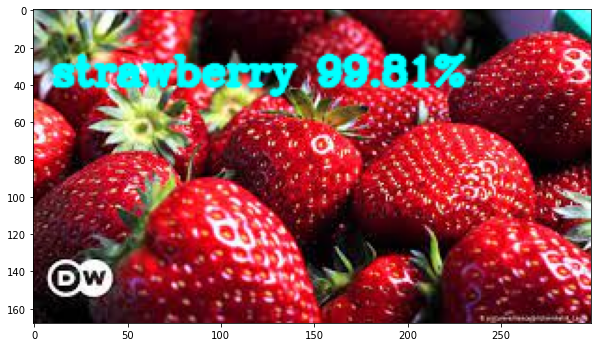

In [10]:
test_idx = random.randint(0, len(img_list)-1)
img_path = img_path_list[0]

with open(img_path, mode='rb') as file:
    payload = bytearray(file.read())
    
response_body, _ = transform_fn(model, payload)
result = json.loads(response_body)
infer_utils.parse_result(result, classes_dict, img_path, show_img=True)

<br>

# 3. Compile Model with SageMaker Neo
---

## Model Compression

In [11]:
with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add(model_trace_name)

## Model Compilation

The code below compiles the model for 4 use cases.
- Cloud (No GPU, ml_c5 instance)
- Cloud (GPU, ml_g4dn instance)
- NVIDIA Jetson nano (No GPU)
- NVIDIA Jetson nano (GPU)

Depending on NVIDIA Jetpack, the CUDA version or TensorRT version of the device may not be compatible, and it takes tens of seconds to load the GPU model, so it is a good strategy to compile and test the CPU model together.

Compilation takes usually 4-6 minutes.

In [12]:
import time, boto3, sagemaker
role = sagemaker.get_execution_role()
bucket = sagemaker.Session().default_bucket()

# For cloud ML inference
compilation_job_cloud_cpu = infer_utils.compile_model_for_cloud(role, bucket, target_device='ml_c5')
compilation_job_cloud_gpu = infer_utils.compile_model_for_cloud(role, bucket, target_device='ml_g4dn')

# For on-device ML inference
compilation_job_jetson_cpu = infer_utils.compile_model_for_jetson(role, bucket, dataset_dir=None, use_gpu=False)
compilation_job_jetson_gpu = infer_utils.compile_model_for_jetson(role, bucket, dataset_dir=None, use_gpu=True)

[INFO] The dataset prefix of the s3 bucket is automatically assigned as 'modelzoo'.
[INFO] The dataset prefix of the s3 bucket is automatically assigned as 'modelzoo'.
[INFO] The dataset prefix of the s3 bucket is automatically assigned as 'modelzoo'.
[INFO] The dataset prefix of the s3 bucket is automatically assigned as 'modelzoo'.


In [13]:
compilation_jobs = [compilation_job_cloud_cpu, compilation_job_cloud_gpu, 
                    compilation_job_jetson_cpu, compilation_job_jetson_gpu]

In [15]:
sm_client = boto3.client('sagemaker')

max_time = time.time() + 15*60 # 15 mins
for job in compilation_jobs:
    while time.time() < max_time:
        resp = sm_client.describe_compilation_job(CompilationJobName=job['job_name'])    
        if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
            print('Running...')
        else:
            print(resp['CompilationJobStatus'], job)
            break
        time.sleep(30)

## Copy Compiled model to local
This code cell copies the compiled model from S3 to local. In the case of the cloud, real-time deployment can be performed by creating the endpoint of the instance, and in the case of on-device like NVIDIA Jetson nano, copy the model to the device and install DLR. With DLR, you can easily infer models with simple API calls without the need to install a separate framework such as PyTorch and TensorFlow.

- Installing DLR: https://neo-ai-dlr.readthedocs.io/en/latest/install.html

In [16]:
model_root_path = 'neo-model'
!rm -rf {model_root_path}
for job in compilation_jobs:
    model_path = f"{model_root_path}/{job['job_name']}"
    os.makedirs(model_path, exist_ok=True)
    !aws s3 cp {job['s3_compiled_model_path']} {model_path} --recursive 

download: s3://sagemaker-us-east-1-143656149352/modelzoo/ml-c5-model-pytorch-2021-08-23-11-10-18-933/neo-output/model-ml_c5.tar.gz to neo-model/ml-c5-model-pytorch-2021-08-23-11-10-18-933/model-ml_c5.tar.gz
download: s3://sagemaker-us-east-1-143656149352/modelzoo/ml-g4dn-model-pytorch-2021-08-23-11-10-19-704/neo-output/model-ml_g4dn.tar.gz to neo-model/ml-g4dn-model-pytorch-2021-08-23-11-10-19-704/model-ml_g4dn.tar.gz
download: s3://sagemaker-us-east-1-143656149352/modelzoo/jetson-nano-model-cpu-pytorch-2021-08-23-11-10-23-531/neo-output/model-LINUX_ARM64.tar.gz to neo-model/jetson-nano-model-cpu-pytorch-2021-08-23-11-10-23-531/model-LINUX_ARM64.tar.gz
download: s3://sagemaker-us-east-1-143656149352/modelzoo/jetson-nano-model-gpu-pytorch-2021-08-23-11-10-24-263/neo-output/model-LINUX_ARM64_NVIDIA.tar.gz to neo-model/jetson-nano-model-gpu-pytorch-2021-08-23-11-10-24-263/model-LINUX_ARM64_NVIDIA.tar.gz
